## Preparation des données

In [ ]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:32<00:00, 32.7MB/s]
100% 2.29G/2.29G [00:32<00:00, 75.1MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/chest-xray-pneumonia.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

## Model

In [ ]:
!pip install keras.preprocessing.image

ERROR: Could not find a version that satisfies the requirement keras.preprocessing.image (from versions: none)
ERROR: No matching distribution found for keras.preprocessing.image


In [ ]:
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Redimensionner les images
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return data

train = get_training_data('/content/chest_xray/train')
test = get_training_data('/content/chest_xray/test')
val = get_training_data('/content/chest_xray/val')


<Axes: xlabel='count'>

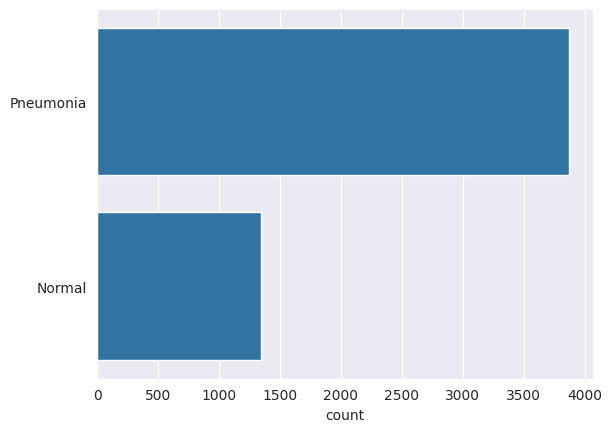

In [ ]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'NORMAL')

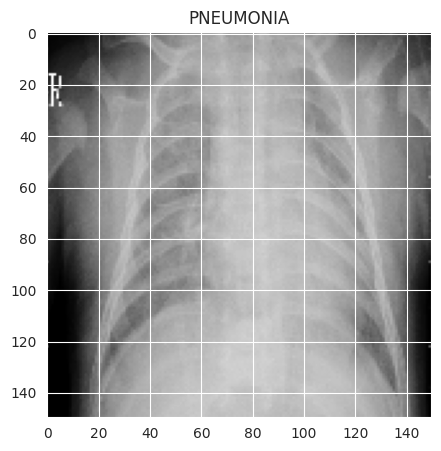

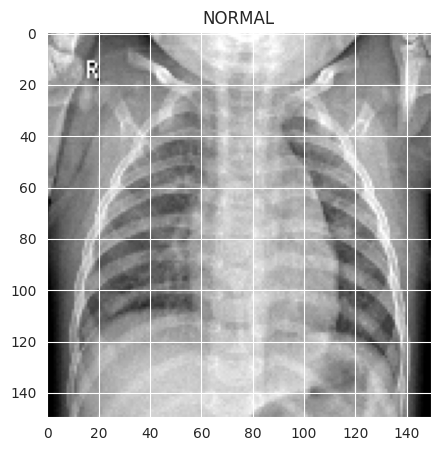

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [ ]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [ ]:
# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [ ]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 64)        2

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 20 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/20
163/163 [==============================] - 351s 2s/step - loss: 0.5117 - accuracy: 0.8422 - val_loss: 47.6047 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
163/163 [==============================] - 346s 2s/step - loss: 0.2700 - accuracy: 0.8995 - val_loss: 22.6863 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
163/163 [==============================] - ETA: 0s - loss: 0.2328 - accuracy: 0.9218
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 348s 2s/step - loss: 0.2328 - accuracy: 0.9218 - val_loss: 30.2181 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/20
163/163 [==============================] - 350s 2s/step - loss: 0.1465 - accuracy: 0.9475 - val_loss: 22.6069 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/20
163/163 [==============================] - 351s 2s/step - loss: 0.1331 - accuracy: 0.9526 - val_loss: 1.0574 - val_accuracy: 0.7500 - lr: 3.0000e-04
Epoch 6/20
163/163 [===========================

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 19s 960ms/step - loss: 0.2695 - accuracy: 0.9167
Loss of the model is -  0.26950323581695557
20/20 [==============================] - 20s 992ms/step - loss: 0.2695 - accuracy: 0.9167
Accuracy of the model is -  91.66666865348816 %


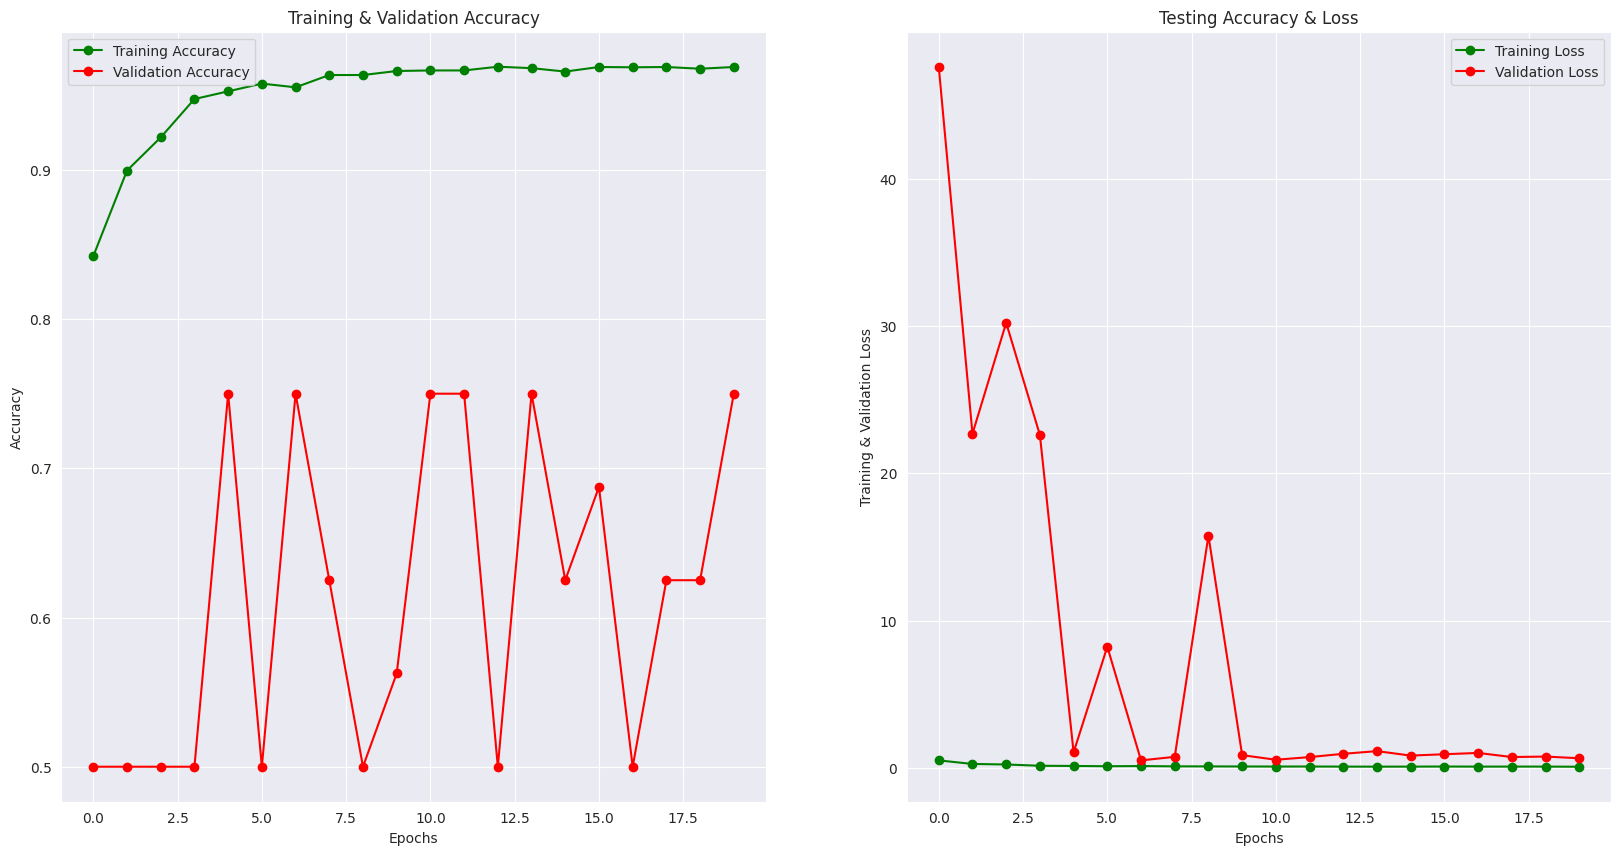

In [ ]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
# Obtenir les prédictions
predictions = model.predict(x_test)

# Appliquer un seuil de 0.5 pour convertir les prédictions en classes
predictions = (predictions >= 0.5).astype(int).flatten()

# Afficher les premières prédictions
predictions

20/20 [==============================] - 11s 546ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.92      0.95      0.93       390
   Normal (Class 1)       0.91      0.87      0.89       234

           accuracy                           0.92       624
          macro avg       0.91      0.91      0.91       624
       weighted avg       0.92      0.92      0.92       624



## Transfer Learning

In [ ]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[383,   7],
       [146,  88]])

In [ ]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

base_model = DenseNet121(input_shape=(180, 180, 3), include_top=False, weights='imagenet', pooling='avg')

base_model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 186, 186, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 90, 90, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormali

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

In [ ]:
train_dir = "/content/chest_xray/train"
test_dir = "/content/chest_xray/test"
val_dir = "/content/chest_xray/val"

In [ ]:
train = image_generator.flow_from_directory(train_dir,
                                            batch_size=8,
                                            shuffle=True,
                                            class_mode='binary',
                                            target_size=(180, 180))

validation = image_generator.flow_from_directory(val_dir,
                                                batch_size=1,
                                                shuffle=False,
                                                class_mode='binary',
                                                target_size=(180, 180))

test = image_generator.flow_from_directory(test_dir,
                                            batch_size=1,
                                            shuffle=False,
                                            class_mode='binary',
                                            target_size=(180, 180))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
import os
# Class weights
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.74
Weight for class 1: 0.26


In [ ]:
#model = Sequential()
base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)

predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
r = model.fit(
    train,
    epochs=10,
    validation_data=validation,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.1632 - accuracy: 0.8375

100/100 [==============================] - 373s 3s/step - loss: 0.1632 - accuracy: 0.8375 - val_loss: 4.3406 - val_accuracy: 0.5625
Epoch 2/10
100/100 [==============================] - 328s 3s/step - loss: 0.1010 - accuracy: 0.8825
Epoch 3/10
100/100 [==============================] - 330s 3s/step - loss: 0.1038 - accuracy: 0.8763
Epoch 4/10
100/100 [==============================] - 327s 3s/step - loss: 0.0852 - accuracy: 0.8888
Epoch 5/10
100/100 [==============================] - 330s 3s/step - loss: 0.0995 - accuracy: 0.8913
Epoch 6/10
100/100 [==============================] - 325s 3s/step - loss: 0.0911 - accuracy: 0.8863
Epoch 7/10
100/100 [==============================] - 327s 3s/step - loss: 0.0869 - accuracy: 0.9050
Epoch 8/10
100/100 [==============================] - 326s 3s/step - loss: 0.0887 - accuracy: 0.8925
Epoch 9/10
100/100 [==============================] - 324s 3s/step - loss: 0.0960 - accuracy: 0.8900
Epoch 10/10
100/100 [==============================] - 327s 

In [ ]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 80s 128ms/step - loss: 0.5889 - accuracy: 0.7949
Test Accuracy: 79.49%
652/652 [==============================] - 518s 794ms/step - loss: 0.1637 - accuracy: 0.9421
Train Accuracy: 94.21%


In [ ]:
cm = confusion_matrix(y_test,predictions)
cm

array([[369,  21],
       [ 31, 203]])

<Axes: >

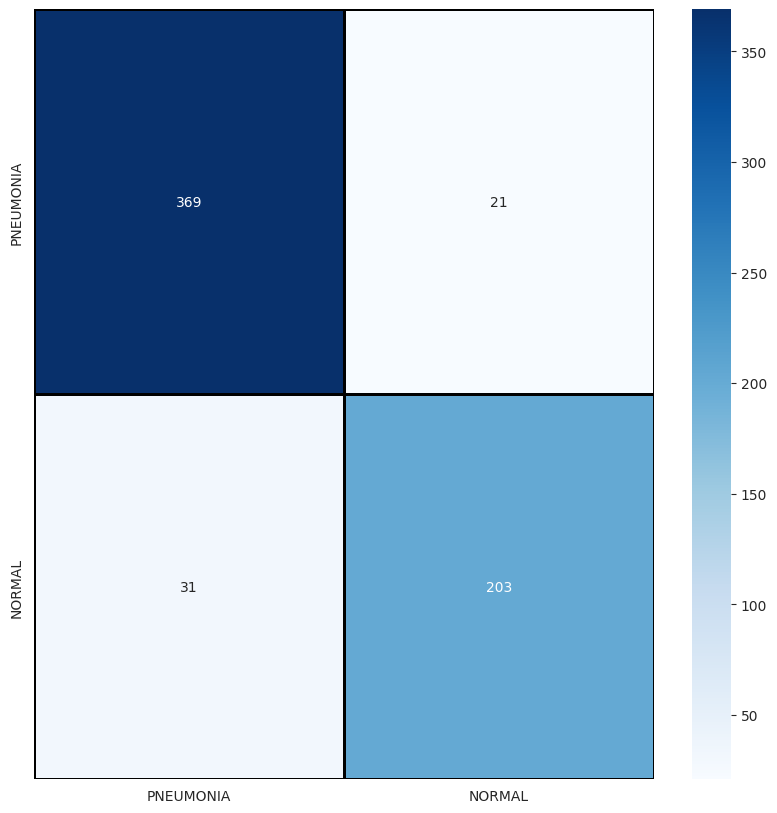

In [ ]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
model.save("/content/model2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Bagging

In [ ]:
def build_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(activation='relu', units=128))
    model.add(Dense(activation='sigmoid', units=1))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
def bagging_ensemble(n_members, X_train, y_train,epochs_numb):
    ensemble_models = []
    for _ in range(n_members):
        train_ix = np.random.choice(X_train.shape[0], size=X_train.shape[0], replace=True)
        trainX_boot, trainy_boot = X_train[train_ix], y_train[train_ix]

        model = build_cnn_model()
        model.fit(trainX_boot, trainy_boot, epochs=epochs_numb, verbose=1)
        ensemble_models.append(model)
    return ensemble_models

def evaluate_each_model(ensemble_models, X_test, y_test):
    for i, model in enumerate(ensemble_models):
        yhats = model.predict(X_test)
        yhats_binary = (yhats > 0.5).astype(int)
        accuracy_i = accuracy_score(y_test, yhats_binary)
        print(f'Model {i+1} Accuracy: {accuracy_i:.3f}')

def evaluate_ensemble_models(ensemble_models,X_test, y_test):

    yhats = np.array([model.predict(X_test) for model in ensemble_models])
    ensemble_predictions = np.mean(yhats, axis=0)
    ensemble_predictions = (ensemble_predictions > 0.5).astype(int)

    return ensemble_predictions

In [ ]:
def generator_to_numpy(generator):
    images, labels = [], []
    for _ in range(len(generator)):
        img_batch, label_batch = next(generator)
        images.extend(img_batch)
        labels.extend(label_batch)
    return np.array(images), np.array(labels)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)


training_set = train_datagen.flow_from_directory(train_folder,
                                                 target_size=(64, 64),
                                                 batch_size=32,
                                                 class_mode='binary',shuffle=True)

validation_set = test_datagen.flow_from_directory(val_folder,
                                                  target_size=(64, 64),
                                                  batch_size=32,
                                                  class_mode='binary',shuffle=True)

test_set = test_datagen.flow_from_directory(test_folder,
                                            target_size=(64, 64),
                                            batch_size=32,
                                            class_mode='binary',shuffle=True)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
X_train, y_train = generator_to_numpy(training_set)
X_test, y_test = generator_to_numpy(test_set)

In [ ]:
ensemble_models = bagging_ensemble(5, X_train, y_train, 5)


Epoch 1/5
163/163 [==============================] - 27s 154ms/step - loss: 0.3873 - accuracy: 0.8288
Epoch 2/5
163/163 [==============================] - 20s 121ms/step - loss: 0.2282 - accuracy: 0.9061
Epoch 3/5
163/163 [==============================] - 21s 129ms/step - loss: 0.1932 - accuracy: 0.9214
Epoch 4/5
163/163 [==============================] - 19s 119ms/step - loss: 0.1790 - accuracy: 0.9317
Epoch 5/5
163/163 [==============================] - 20s 123ms/step - loss: 0.1482 - accuracy: 0.9454
Epoch 1/5
163/163 [==============================] - 21s 122ms/step - loss: 0.3774 - accuracy: 0.8347
Epoch 2/5
163/163 [==============================] - 21s 132ms/step - loss: 0.2286 - accuracy: 0.9084
Epoch 3/5
163/163 [==============================] - 20s 124ms/step - loss: 0.1981 - accuracy: 0.9224
Epoch 4/5
163/163 [==============================] - 21s 131ms/step - loss: 0.1600 - accuracy: 0.9390
Epoch 5/5
163/163 [==============================] - 20s 122ms/step - loss: 0.1404

In [ ]:
from sklearn.metrics import accuracy_score

evaluate_each_model(ensemble_models,X_test, y_test)

predictions = evaluate_ensemble_models(ensemble_models,X_test, y_test)
accuracy = accuracy_score(y_test, predictions)
print(f'Ensemble Accuracy: {accuracy:.3f}')

20/20 [==============================] - 2s 89ms/step
Model 1 Accuracy: 0.881
20/20 [==============================] - 2s 79ms/step
Model 2 Accuracy: 0.854
20/20 [==============================] - 1s 58ms/step
Model 3 Accuracy: 0.833
20/20 [==============================] - 1s 54ms/step
Model 4 Accuracy: 0.856
20/20 [==============================] - 1s 54ms/step
Model 5 Accuracy: 0.888
20/20 [==============================] - 1s 29ms/step
Ensemble Accuracy: 0.870


## Boosting

In [ ]:
import numpy as np
import os
import cv2
import time
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Définir les étiquettes et la taille des images
labels = ['PNEUMONIA', 'NORMAL']
img_size = 64  # Taille réduite des images pour accélérer le traitement

# Fonction pour charger les données de formation
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Redimensionner les images
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

# Charger les données
train_data = get_training_data('/content/chest_xray/train')
test_data = get_training_data('/content/chest_xray/test')

# Séparer les caractéristiques et les étiquettes
X_train = np.array([item[0] for item in train_data]).reshape(-1, img_size * img_size)
y_train = np.array([item[1] for item in train_data])
X_test = np.array([item[0] for item in test_data]).reshape(-1, img_size * img_size)
y_test = np.array([item[1] for item in test_data])

# Normaliser les données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Définir et entraîner le modèle de boosting avec validation croisée pour l'optimisation des hyperparamètres
base_model = DecisionTreeClassifier(max_depth=1)  # Utiliser des arbres de décision faibles comme classificateurs de base

# Définir les paramètres pour GridSearchCV
param_grid = {
    'n_estimators': [10, 20],  # Réduire le nombre d'estimateurs pour gagner du temps
    'base_estimator__max_depth': [1, 2]
}

boosting_model = AdaBoostClassifier(base_estimator=base_model, random_state=42)

# Démarrer le chronomètre
start_time = time.time()

grid_search = GridSearchCV(estimator=boosting_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)  # Réduire les folds de CV pour gagner du temps
grid_search.fit(X_train, y_train)

# Arrêter le chronomètre
end_time = time.time()
elapsed_time = end_time - start_time

# Afficher les meilleurs paramètres trouvés par GridSearchCV
print(f"Best parameters found: {grid_search.best_params_}")

# Faire des prédictions sur l'ensemble de test avec le meilleur modèle trouvé
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculer la précision
accuracy = accuracy_score(y_test, y_pred)
print(f'Optimized Boosting Model Accuracy: {accuracy * 100:.2f}%')
print(f'Time taken for training and evaluation: {elapsed_time:.2f} seconds')

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/en

Best parameters found: {'base_estimator__max_depth': 2, 'n_estimators': 20}
Optimized Boosting Model Accuracy: 75.48%
Time taken for training and evaluation: 368.12 seconds


### Gradient Boosting

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)


training_set = train_datagen.flow_from_directory(train_folder,
                                                 target_size=(64, 64),
                                                 batch_size=32,
                                                 class_mode='binary',shuffle=True)

validation_set = test_datagen.flow_from_directory(val_folder,
                                                  target_size=(64, 64),
                                                  batch_size=32,
                                                  class_mode='binary',shuffle=True)

test_set = test_datagen.flow_from_directory(test_folder,
                                            target_size=(64, 64),
                                            batch_size=32,
                                            class_mode='binary',shuffle=True)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
def build_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', name='dense_layer'))
    model.add(Dense(activation='relu', units=128))
    model.add(Dense(activation='sigmoid', units=1))
    model.summary()
    return model

In [ ]:
def generator_to_numpy(generator):
    images, labels = [], []
    for _ in range(len(generator)):
        img_batch, label_batch = next(generator)
        images.extend(img_batch)
        labels.extend(label_batch)
    return np.array(images), np.array(labels)

In [ ]:
X_train, y_train = generator_to_numpy(training_set)
X_test, y_test = generator_to_numpy(test_set)

In [ ]:
my_model = build_cnn_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_layer (Dense)         (None, 256)               1

In [ ]:
from keras.models import Model

intermediate_layers_model = Model(inputs=my_model.inputs,
                                 outputs=my_model.get_layer('dense_layer').output)

intermediate_layers_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 6272)              0     

In [ ]:
my_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = my_model.fit(X_train, y_train,
                              epochs = 5,
                              shuffle=True,
                              validation_data = validation_set,
                              verbose = 1,
                              )

Epoch 1/5
163/163 [==============================] - 23s 132ms/step - loss: 0.3210 - accuracy: 0.8583 - val_loss: 0.4383 - val_accuracy: 0.7500
Epoch 2/5
163/163 [==============================] - 21s 129ms/step - loss: 0.2116 - accuracy: 0.9139 - val_loss: 0.2845 - val_accuracy: 0.9375
Epoch 3/5
163/163 [==============================] - 23s 141ms/step - loss: 0.1663 - accuracy: 0.9323 - val_loss: 0.8740 - val_accuracy: 0.5625
Epoch 4/5
163/163 [==============================] - 21s 129ms/step - loss: 0.1490 - accuracy: 0.9411 - val_loss: 0.3869 - val_accuracy: 0.7500
Epoch 5/5
163/163 [==============================] - 28s 175ms/step - loss: 0.1334 - accuracy: 0.9482 - val_loss: 0.4362 - val_accuracy: 0.8125


In [ ]:
y_preds = my_model.predict(X_test)
y_preds = (y_preds > 0.5).astype(int)


20/20 [==============================] - 1s 56ms/step


In [ ]:
import pandas as pd
intermediate_outputs = intermediate_layers_model.predict(X_train)
intermediate_outputs = pd.DataFrame(data=intermediate_outputs)

163/163 [==============================] - 13s 78ms/step


In [ ]:
intermediate_test_output = intermediate_layers_model.predict(X_test)
intermediate_test_output = pd.DataFrame(data=intermediate_test_output)

20/20 [==============================] - 1s 43ms/step


In [ ]:
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

xgbmodel = XGBClassifier(objective='binary:logistic')
xgbmodel.fit(intermediate_outputs, y_train)
xg_preds_proba = xgbmodel.predict_proba(intermediate_test_output)
xg_preds = (xg_preds_proba[:, 1] > 0.5).astype(int)

accuracy = accuracy_score(y_test, xg_preds)
print(f'Model Accuracy: {accuracy:.3f}')

Model Accuracy: 0.877
